<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Loading-data-from-Tara" data-toc-modified-id="Loading-data-from-Tara-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Loading data from Tara</a></span></li><li><span><a href="#Spearman-correlation-matrix" data-toc-modified-id="Spearman-correlation-matrix-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Spearman correlation matrix</a></span><ul class="toc-item"><li><span><a href="#Filter-the-data" data-toc-modified-id="Filter-the-data-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Filter the data</a></span></li><li><span><a href="#Compute-correlation-matrix" data-toc-modified-id="Compute-correlation-matrix-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Compute correlation matrix</a></span></li><li><span><a href="#Clustering" data-toc-modified-id="Clustering-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Clustering</a></span></li></ul></li><li><span><a href="#Microbial-ecological-network-inference" data-toc-modified-id="Microbial-ecological-network-inference-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Microbial ecological network inference</a></span><ul class="toc-item"><li><span><a href="#Loading-the-necessary-R-packages" data-toc-modified-id="Loading-the-necessary-R-packages-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Loading the necessary R packages</a></span></li><li><span><a href="#Convert-the-data-object" data-toc-modified-id="Convert-the-data-object-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Convert the data object</a></span></li><li><span><a href="#Filtering" data-toc-modified-id="Filtering-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Filtering</a></span></li><li><span><a href="#Running-SPIEC-EASI-on-the-dataset" data-toc-modified-id="Running-SPIEC-EASI-on-the-dataset-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Running SPIEC-EASI on the dataset</a></span></li><li><span><a href="#Graphs-visualizations" data-toc-modified-id="Graphs-visualizations-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Graphs visualizations</a></span></li><li><span><a href="#Exercice" data-toc-modified-id="Exercice-4.6"><span class="toc-item-num">4.6&nbsp;&nbsp;</span>Exercice</a></span></li></ul></li><li><span><a href="#Biclustering-of-the-dataset" data-toc-modified-id="Biclustering-of-the-dataset-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Biclustering of the dataset</a></span><ul class="toc-item"><li><span><a href="#Normalization" data-toc-modified-id="Normalization-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Normalization</a></span></li><li><span><a href="#Filtering" data-toc-modified-id="Filtering-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Filtering</a></span></li><li><span><a href="#Biclustering-on-ISA" data-toc-modified-id="Biclustering-on-ISA-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Biclustering on ISA</a></span></li></ul></li></ul></div>

Authors: [Samuel Chaffron](https://www.ls2n.fr/annuaire/Samuel%20CHAFFRON)
and [Nils Giordano](https://www.ls2n.fr/annuaire/Nils%20GIORDANO)

With credits to Marko Budinich, Erwan Delage

# Introduction

For this practical exercice, we will use publicly available data from the Tara Oceans project to identify clusters of microorganisms in the global ocean.

Data are from this [Ocean-Microbiome EMBL website](http://ocean-microbiome.embl.de/companion.html), which is a *companion* website for the publication:
>[Structure and function of the global ocean microbiome](www.sciencemag.org/content/348/6237/1261359.long)  
Sunagawa, Coelho, Chaffron, et al., Science, 2015

In particular, we will use the Tara miTAGs 16S data (OTUs and taxonomy files, already downloaded for this session).

**Tool: Jupyter Notebook**

This document is called a [Jupyter Notebook](http://jupyter.org/).
> The Jupyter Notebook is an open-source web application that allows you to create and share documents that contain live code, equations, visualizations and narrative text. Uses include: data cleaning and transformation, numerical simulation, statistical modeling, data visualization, machine learning, and much more.

Jupyter Notebooks are widely used in Data Science and are compatible with many langages (Julia, Python, R, C++...). Here we will exclusively use the R programming language.

Jupyter Notebooks are made of *cells* of text or code that you can edit and execute at will. All the variables are stored in background and shared between cells. Click on the code cell below and press `<SHIFT> + <RETURN>`.

In [62]:
print("Hello World!")

[1] "Hello World!"


You are able to access this notebook online thanks to [mybinder](https://mybinder.org/), which associates [JupyterHub](https://jupyterhub.readthedocs.io/en/latest/) and [Docker](https://www.docker.com/) to create interactive instances of a notebook.

# Loading data from Tara

The miTAGs 16S OTUs and taxonomy data have already been formatted in tables by the publication authors. You can find them in the `Data/` folder:

- OTU table: `miTAG.taxonomic.profiles.release.OTUtable.tsv`
- TAX table: `miTAG.taxonomic.profiles.release.TAXtable.tsv`

The code below read these files and load them into R table objects (run it with `<SHIFT> + <RETURN>`).

In [ ]:
DIR = 'Data/'

# Load abundance matrix
otumat = read.csv(paste(DIR,"miTAG.taxonomic.profiles.release.OTUtable.tsv",sep=""),
                  sep="\t", row.names=1, check.names=FALSE)
taxmat = read.csv(paste(DIR,"miTAG.taxonomic.profiles.release.TAXtable.tsv",sep=""),
                  sep="\t", row.names=1, check.names=FALSE)

You can interactively look at the content of the `otumat` and `taxmat` variables simply by typing their names in a R shell.

**Q: Look at both tables by editing and executing the code cell below. What are the rows and columns?**

In [ ]:
## ENTER IN THIS CELL THE NAME OF THE VARIABLE YOU WANT TO DISPLAY

In what follows we will use these two tables to:
- create a correlation matrix of species abundances around the global ocean
- infer and display a network of association between species using SPIEC-EASI
- compute display (bi-)clusters of association

This is 3 different ways to look at microorganism organization. Each part are independent and provide different information on the dataset.

# Spearman correlation matrix

## Filter the data

By using the R function `dim()` you can obtain the size of a R object. Note that you can look at the documentation of any R function by executing `?function` in a code cell.

**Q: How much Tara samples and OTUs do we have in the `otumat` table?**

In [ ]:
?dim

In practice, most of the OTU are either hardly detectable or only present in a small fraction of the samples. To simplify the analysis, it is common practice to filter out these OTU from our dataset.

This is performed by the code cell below.

**Q: What kind of filtering is performed by the code below? What are the tresholds? How much did we reduce the size of the dataset?**

In [ ]:
# OTUs as columns
totus = t(otumat)

# function to perform pre-filtering on OTU with low abundance relative to total abundance
# OTUS with an abundance lower than 0.01% of total abundance are removed from the table
low.count.removal = function(
  data, # OTU count data frame of size n (sample) x p (OTU)
  percent=0.01 # cutoff chosen
){
  keep.otu = which(colSums(data)*100/(sum(colSums(data))) > percent)
  data.filter = data[,keep.otu]
  return(list(data.filter = data.filter, keep.otu = keep.otu))
}

# function to perform pre-filtering on OTU with low presence across stations
# OTUS that appears in less than 5% of stations are removed from the table
min.stations.removal = function(
  data, # OTU count data frame of size n (sample) x p (OTU)
  percent=0.05 # cutoff chosen
){
  keep.otu = which(colSums(data != 0) > percent * dim(data)[1])
  data.filter = data[,keep.otu]
  return(list(data.filter = data.filter, keep.otu = keep.otu))
}


# Initialize thresholds (in %)
thresholdAbundance = 0.1
thresholdPresence = 0.6

# Remove OTUs with relative abundance lower than 0.1% of total abundance
cat("NB stations :",dim(totus)[1],"\n")
cat("NB otus before abundance filter :",dim(totus)[2],"\n")
nbOtusInitial = dim(totus)[2]

ftr = low.count.removal(totus, thresholdAbundance)
totus = totus[,ftr$keep.otu]
nbOtusAfterAbFilter = dim(totus)[2]
cat("NB otus after abundance filter :",nbOtusAfterAbFilter,"\n")

# Filter OTU's on presence in minimum number of stations
ftr = min.stations.removal(totus,thresholdPresence)
totus = totus[,ftr$keep.otu]
nbOtusAfterPrFilter = dim(totus)[2]
cat("NB otus after presence filter :",nbOtusAfterPrFilter,"\n")

## Compute correlation matrix

Are there species for which the abundance accross the samples correlate?

We can have a quick glance by simply computing the correlation matrix of our dataset.

**Q: Use the function `cor()` of R to plot the correlation matrix  of the `totus` object. Store the result in a variable `cormat` and display it. What are the rows and columns of the matrix? What can you observe on the diagonal?**

In [57]:
totus

,unclassified,AACY024102418.157.1623,KC003383.1.1321,EU394547.1.1451,X52169.1.1473,EU802966.1.1361,EU802925.1.1450,AY664224.1.1233,GU940990.1.1405,GU940771.1.1349,⋯,HQ671819.1.1446,AACY020555764.489.1966,EU802894.1.1450,EU803007.1.1326,FJ745251.1.1308,EF572586.1.1452,EF574663.1.1445,AACY020255495.903.2404,AY664000.1.1252,EU802915.1.1434
TARA_018_DCM_0.22-1.6,5101,1021,2697,605,3786,530,794,486,599,332,⋯,0,120,41,165,171,148,248,166,7,84
TARA_018_SRF_0.22-1.6,5314,1348,2580,909,3672,628,724,619,608,448,⋯,2,173,35,229,203,214,236,160,15,108
TARA_023_DCM_0.22-1.6,2135,351,273,1018,225,71,92,284,65,147,⋯,1,5,15,65,115,12,128,291,66,5
TARA_023_SRF_0.22-1.6,2980,1017,138,841,205,115,225,651,48,369,⋯,1,9,26,73,355,37,132,293,31,13
TARA_025_DCM_0.22-1.6,4671,511,2085,1104,1763,472,487,361,448,236,⋯,1,49,25,99,142,48,107,107,54,55
TARA_025_SRF_0.22-1.6,3981,1221,418,778,599,178,400,765,119,514,⋯,2,7,37,79,436,45,153,409,322,43
TARA_030_DCM_0.22-1.6,7049,2048,1691,1189,2108,463,393,882,387,589,⋯,0,35,50,334,392,57,319,119,164,76
TARA_030_SRF_0.22-1.6,3357,686,123,200,166,97,173,734,37,426,⋯,1,4,24,211,741,21,254,228,36,25
TARA_031_SRF_0.22-1.6,3809,825,2225,247,137,1942,2014,450,1865,479,⋯,0,57,245,139,81,121,79,110,97,398
TARA_032_DCM_0.22-1.6,11084,1458,895,807,247,629,520,276,500,303,⋯,2,61,79,70,32,78,34,75,89,131


,unclassified,AACY024102418.157.1623,KC003383.1.1321,EU394547.1.1451,X52169.1.1473,EU802966.1.1361,EU802925.1.1450,AY664224.1.1233,GU940990.1.1405,GU940771.1.1349,⋯,HQ671819.1.1446,AACY020555764.489.1966,EU802894.1.1450,EU803007.1.1326,FJ745251.1.1308,EF572586.1.1452,EF574663.1.1445,AACY020255495.903.2404,AY664000.1.1252,EU802915.1.1434
unclassified,"1,00000000","-0,03783855","0,03061636","0,22804179","0,05812425","-0,09729694","-0,181144672","-0,027505712","-0,12682728","-0,13384711",⋯,"0,20799583","0,06160505","-0,35493904","-0,01152171","-0,10754919","-0,13428469","-0,16621721","-0,131776691","-0,084605668","-0,15854325"
AACY024102418.157.1623,"-0,03783855","1,00000000","0,37009151","0,17196396","0,28621271","0,47635827","0,504205262","0,557675327","0,46369115","0,76494106",⋯,"-0,27487230","0,40021094","0,42990473","0,67198196","0,31978398","0,41678141","0,68355468","0,472831875","0,003822458","0,47496648"
KC003383.1.1321,"0,03061636","0,37009151","1,00000000","0,15514661","0,68854340","0,68616601","0,714492880","0,158721335","0,73295501","0,32115527",⋯,"-0,26493124","0,22188183","0,27719614","0,56605088","0,04969069","0,25764190","0,35667978","0,090531326","-0,238334991","0,54597746"
EU394547.1.1451,"0,22804179","0,17196396","0,15514661","1,00000000","0,27494119","-0,12887417","-0,154611029","0,280803198","-0,15580640","0,24093013",⋯,"-0,28880947","0,25204795","-0,26810496","0,09677245","0,21213488","0,26656309","0,17897147","0,013747104","-0,026235427","-0,18483223"
X52169.1.1473,"0,05812425","0,28621271","0,68854340","0,27494119","1,00000000","0,05764513","0,200336082","0,260770408","0,15583417","0,17530002",⋯,"-0,14762635","0,34867451","-0,11312134","0,27082860","0,27302105","0,33767724","0,51113148","0,199920961","-0,203292041","-0,07597579"
EU802966.1.1361,"-0,09729694","0,47635827","0,68616601","-0,12887417","0,05764513","1,00000000","0,952245108","0,158151077","0,97861291","0,52132268",⋯,"-0,24419303","0,17588908","0,68715052","0,67766782","-0,11444104","0,24028343","0,25208424","0,099660872","-0,035553631","0,95991584"
EU802925.1.1450,"-0,18114467","0,50420526","0,71449288","-0,15461103","0,20033608","0,95224511","1,000000000","0,180575830","0,98251390","0,48695834",⋯,"-0,23547218","0,23240612","0,67605622","0,64448364","-0,02282108","0,29339691","0,33917200","0,169468380","-0,099611793","0,90986037"
AY664224.1.1233,"-0,02750571","0,55767533","0,15872133","0,28080320","0,26077041","0,15815108","0,180575830","1,000000000","0,11804336","0,74141362",⋯,"0,04763090","0,25987026","0,17237705","0,47211130","0,68382466","0,49150503","0,63837037","0,397701997","0,218502182","0,17170723"
GU940990.1.1405,"-0,12682728","0,46369115","0,73295501","-0,15580640","0,15583417","0,97861291","0,982513896","0,118043361","1,00000000","0,46256382",⋯,"-0,22330338","0,22490624","0,65846502","0,64149411","-0,11560310","0,26631108","0,27199968","0,113573359","-0,099252853","0,92426433"
GU940771.1.1349,"-0,13384711","0,76494106","0,32115527","0,24093013","0,17530002","0,52132268","0,486958336","0,741413617","0,46256382","1,00000000",⋯,"-0,36803944","0,48082118","0,51762981","0,68928758","0,35343786","0,65097781","0,65386580","0,428260632","0,248304731","0,53307641"


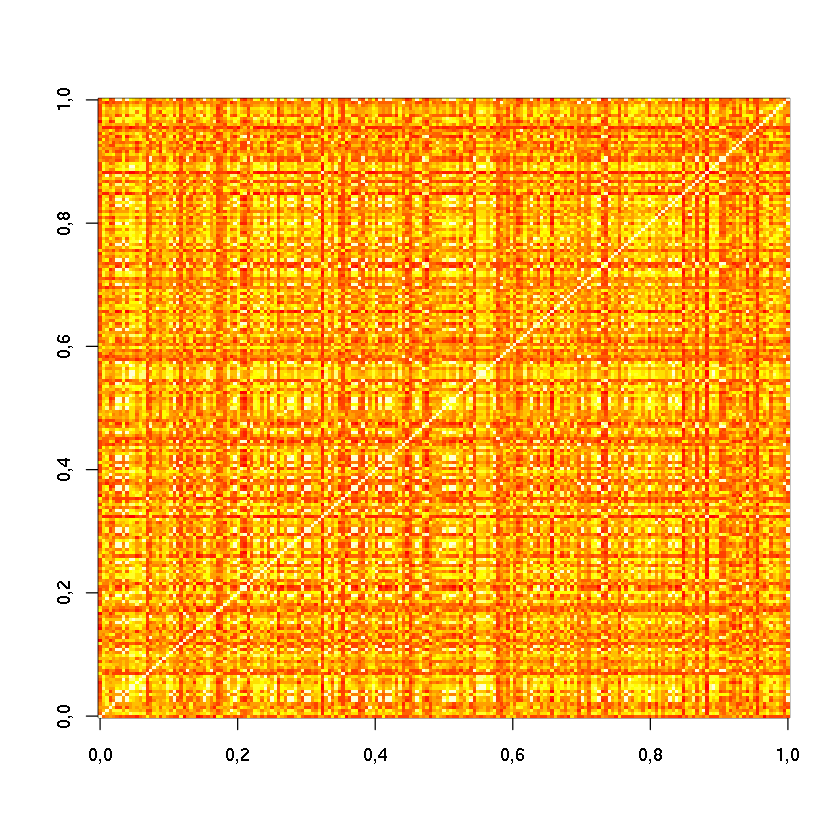

In [58]:
cormat <- cor(totus)
cormat
image(cormat)

The matrix can also be visualized using the code below.

In [ ]:
library(ggplot)

ggplot(data = cormat, aes(x=OTUs, y=OTUs, fill=value)) + 
  geom_tile()

**Q: Look at the documentation of the `cor()` function. What is the default method used?**  
**Q: Reproduce the correlation with the `spearman` method. Compare.**

In [ ]:
## REPRODUCE THE CORRELATION ANALYSIS WITH THE SPEARMAN METHOD

Since we are computing thousands of correlations (200x200), there is a high probability we observe correlations that are just due to chance (i.e. that are not statistically significant).

The `cor()` function does not return the p-value of the correlation. We need for this to load an extra package, `Hmisc`, that provides the `rcorr()` function.

In [ ]:
library(Hmisc)

**Q: Use the `rcorr()` function with the `spearman` method on our dataset and store the result into a `cormat2` variable. What does the `cormat2` object contains?**

In [56]:
## REPRODUCE THE CORRELATION ANALYSIS WITH RCORR()

If you want to extract the p-values or the correlation coefficients from the `cormat2`object, use this:

In [ ]:
# Extract the correlation coefficients
cormat2$r
# Extract p-values
cormat2$P

**Q: Find a way to visualize the matrix of p-values. Are most correlations significant?**

In [59]:
## VISUALIZE THE P-VALUE MATRIX

At this point, one could use the p-value matrix to filter out correlations that are not significant (not done here).

## Clustering

We plotted 1-vs-1 correlation matrixes, so we are able to see if two OTUs are associated in the dataset. What we actually would like to see is if groups of OTUs occupy the same ecological niche. For this, we can use clustering techniques that will automatically compute a correlation matrix and organize it by groups.

For instance, we can use the `heatmap.2()` function from the `gplots` package.

In [ ]:
library(gplots)

heatmap.2(matrix, hclustfun=function(c) hclust(c, method="ward"),
          trace="none", cexRow=.5, cexCol=.5, margins=c(10,15),
          col=rev(heat.colors(length(colnames(matrix)))))

**Q: Comment on the heatmap generate.**

# Microbial ecological network inference

More complex methods exist to infer ecological association between OTUs, and new ones are constantly developed by the research community. Here we will use the method SPIEC-EASI, published in *Plos Computational Biology* in 2015.
> SPIEC-EASI (SParse InversE Covariance Estimation for Ecological Association
Inference) exploits the fact that under certain assumptions (that all relevant
variables are being considered and the data are multivariate normally
distributed), the inverse covariance matrix corresponds to a network without
indirect edges. SPIEC-EASI estimates the inverse covariance
matrix from sequencing data. The inference of networks using the inverse
covariance matrix is also known in the literature as Graphical Gaussian model
and the inverse covariance matrix is also referred to as precision or partial
correlation matrix. SPIEC-EASI is implemented in R, for further details about
SPIEC-EASI, please check the associated publication:
http://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1004226

Conveniently, the authors made a R package available on [Github](https://github.com/zdk123/SpiecEasi) for the community.
>This package will be useful to anybody who wants to infer graphical models for all sorts of compositional data, though primarily intended for microbiome relative abundance data (generated from 16S amplicon sequence data). It also includes a generator for [overdispersed, zero inflated] multivariate, correlated count data.

## Loading the necessary R packages

In [ ]:
# SPIEC-EASI R package installation (https://github.com/zdk123/SpiecEasi)
library(devtools)
library(huge)
#install_github("zdk123/SpiecEasi")
library(SpiecEasi)
# Phyloseq installation
library(gtools)
#source('http://bioconductor.org/biocLite.R')
#biocLite('phyloseq')
library(phyloseq)
# iGraph installation
library(Matrix)
library(igraph)

## Convert the data object

We start by converting the data table into objects that can be manipulated by the SpiecEasi package.

In [60]:
otus = otu_table(otumat, taxa_are_rows = TRUE)
taxa = tax_table(as.matrix(taxmat))
mat = phyloseq(otus, taxa)

# OTUs as columns
totus = t(otus)

ERROR: Error in otu_table(otumat, taxa_are_rows = TRUE): impossible de trouver la fonction "otu_table"


**Q: What contains the `otus` and `taxa` variables? What is the `mat` variable? What is the role of the function `t()`?**

In [61]:
## USE THIS CELL TO OBSERVE THE OBJECTS

## Filtering

As above, we will filter OTUs based on their abundance in the dataset. Just run the code cell below.

In [ ]:
# function to perform pre-filtering on OTU with low abundance relative to total abundance
# OTUS with an abundance lower than 0.01% of total abundance are removed from the table
low.count.removal = function(
  data, # OTU count data frame of size n (sample) x p (OTU)
  percent=0.01 # cutoff chosen
){
  keep.otu = which(colSums(data)*100/(sum(colSums(data))) > percent)
  data.filter = data[,keep.otu]
  return(list(data.filter = data.filter, keep.otu = keep.otu))
}

# function to perform pre-filtering on OTU with low presence across stations
# OTUS that appears in less than 5% of stations are removed from the table
min.stations.removal = function(
  data, # OTU count data frame of size n (sample) x p (OTU)
  percent=0.05 # cutoff chosen
){
  keep.otu = which(colSums(data != 0) > percent * dim(data)[1])
  data.filter = data[,keep.otu]
  return(list(data.filter = data.filter, keep.otu = keep.otu))
}


# Initialize thresholds (in %)
thresholdAbundance = 0.1
thresholdPresence = 0.6

# Remove OTUs with relative abundance lower than 0.1% of total abundance
cat("NB stations :",dim(totus)[1],"\n")
cat("NB otus before abundance filter :",dim(totus)[2],"\n")
nbOtusInitial = dim(totus)[2]

ftr = low.count.removal(totus, thresholdAbundance)
totus = totus[,ftr$keep.otu]
nbOtusAfterAbFilter = dim(totus)[2]
cat("NB otus after abundance filter :",nbOtusAfterAbFilter,"\n")

# Filter OTU's on presence in minimum number of stations
ftr = min.stations.removal(totus,thresholdPresence)
totus = totus[,ftr$keep.otu]
nbOtusAfterPrFilter = dim(totus)[2]
cat("NB otus after presence filter :",nbOtusAfterPrFilter,"\n")

# update phyloseq object after filtering
otus = otu_table(totus, taxa_are_rows = F)
taxa = tax_table(as.matrix(taxa[colnames(otus),]))
physeqo = phyloseq(t(otus), taxa)

## Running SPIEC-EASI on the dataset

To simplify this practical exercice, we will use the default parameters. In general, it is good practice to have a look at the documentation and the original publication to adjust the parameters to your problem of interest.

The example below does not cover all possible options and parameters. For
example, other generative network models are available, the lambda.min.ratio
(the scaling factor that determines the minimum sparsity/lambda parameter)
shown here might not be right for your dataset. Additionally, increasing the
rep.num argument (the number of StARS subsamples) may result in better performance.

You can get an idea of the level of customisation that is possible by displaying the `spiec.easi()` documentation using `?spiec.easi`.

In [ ]:
# SPIEC-EASI default parameters
lambda.min.ratio = 1e-2
nlambda = 20

# SPIEC-EASI run
physeqo.mb = spiec.easi(physeqo, method='mb', lambda.min.ratio=lambda.min.ratio, nlambda=nlambda)
print(physeqo.mb)

In the next step, we build an iGraph object. We extract the regression coefficients from the SPIEC-EASI
output, which for method `mb` is achieved with command `getOptBeta()`.
The regression coefficient matrix is not symmetric and can be symmetrised with
command `symBeta()`

In [ ]:
adj   = physeqo.mb
adj.g = adj2igraph(symBeta(getOptBeta(adj), mode='maxabs'), vertex.attr=list(name=taxa_names(physeqo)))
hist(E(adj.g)$weight)

## Graphs visualizations

We should now be able to display the associations that we have just infered using SPIEC-EASI.

They are several way of visualization, simply using iGraph:

In [ ]:
## Using iGraph
## set size of vertex proportional to clr-mean
vsize <- rowMeans(clr(otus, 1))+3
## set layout
am.coord <- layout_with_graphopt(adj.g)
plot(adj.g, layout=am.coord, vertex.size=vsize, vertex.label=NA, vertex.color="aquamarine2", edge.color="black", edge.width=E(adj.g)$weight, main="Tara euphotic network")
# degree stats
dd.mb <- degree.distribution(adj.g)
plot(0:(length(dd.mb)-1), dd.mb, ylim=c(0,.35), type='b',
     ylab="Frequency", xlab="Degree", main="Degree Distributions")

... or using physeq:

In [ ]:
## Using phyloseq
#pdf(paste(DIR,"SPIEC-EASI.networks.pdf",sep=""), paper = "a4r", width=29, height=21)
plot_network(adj.g, taxa, type='taxa', color="Genus", label=NULL)
plot_network(adj.g, taxa, type='taxa', color="Class", label=NULL)
plot_network(adj.g, taxa, type='taxa', color="Phylum", label=NULL)
#dev.off()

# Export graph
#write_graph(adj.g, paste(DIR,"Tara.SUR.DCM.genus.merged16S.graphml",sep=""), format="graphml")

**Q: Comment on the graph created. Can you observe some associations?**

## Exercice

Extract the number of positive and negative associations inferred by SPIEC-EASI.

They can be obtained from the matrix of regression coefficients stored in the adjancency matrix (adj.g)

In [ ]:
# YOUR CODE HERE

# Biclustering of the dataset

We saw earlier that we can observe clusters of correlations between the OTUs. More advances techniques allow to clusterize the data set for rows (samples) and OTUs (columns) at the same time, a technique called [biclustering](https://en.wikipedia.org/wiki/Biclustering).

In [ ]:
library(biclust) #from CRAN
library(isa2) #from CRAN

In [63]:
raw_data <- read.table('Data/miTAG.taxonomic.profiles.release.OTUtable.tsv',header = T,sep="\t")

data_table <- raw_data[,-1] #Drop first column, the otu names
data_otusn <- raw_data[, 1] #Get first column only, the otu names

dim(data_table)

[1] 35651   105

In [85]:
data_table

TARA_018_DCM_0.22.1.6,TARA_018_SRF_0.22.1.6,TARA_023_DCM_0.22.1.6,TARA_023_SRF_0.22.1.6,TARA_025_DCM_0.22.1.6,TARA_025_SRF_0.22.1.6,TARA_030_DCM_0.22.1.6,TARA_030_SRF_0.22.1.6,TARA_031_SRF_0.22.1.6,TARA_032_DCM_0.22.1.6,⋯,TARA_084_SRF_0.22.3,TARA_085_DCM_0.22.3,TARA_085_SRF_0.22.3,TARA_093_DCM_0.22.3,TARA_093_SRF_0.22.3,TARA_094_SRF_0.22.3,TARA_096_SRF_0.22.3,TARA_098_DCM_0.22.3,TARA_098_SRF_0.22.3,TARA_099_SRF_0.22.3
5101,5314,2135,2980,4671,3981,7049,3357,3809,11084,⋯,6554,5632,6770,2253,813,2337,4100,4823,2097,2763
1021,1348,351,1017,511,1221,2048,686,825,1458,⋯,0,0,2,324,171,2720,3287,529,1480,1816
2697,2580,273,138,2085,418,1691,123,2225,895,⋯,0,0,0,26,117,1084,989,1678,430,1088
605,909,1018,841,1104,778,1189,200,247,807,⋯,1,0,0,2664,1174,1145,938,493,374,483
3786,3672,225,205,1763,599,2108,166,137,247,⋯,0,0,0,16,99,1432,1174,905,75,529
530,628,71,115,472,178,463,97,1942,629,⋯,0,0,0,24,39,332,580,591,488,877
794,724,92,225,487,400,393,173,2014,520,⋯,0,1,1,54,56,453,484,366,421,854
486,619,284,651,361,765,882,734,450,276,⋯,469,422,736,397,315,992,830,143,336,309
599,608,65,48,448,119,387,37,1865,500,⋯,0,0,0,1,19,211,421,525,348,756
332,448,147,369,236,514,589,426,479,303,⋯,19,18,21,319,289,703,911,161,403,450


## Normalization

Most clustering techniques require the data to be normalized (either by row, column, or both). This can be done easily in R by computing the sum of each row and dividing the whole matrix by the vector obtained.

In [87]:
total_reads <- apply(otumat,2,sum)
norm_read <- t(t(otumat) / total_reads) #Normalize by total reads

## Filtering

As seen earlier, we will filter out data that are below a given abundance threshold.

**Q: What are the thresholds used in the code below?**

In [92]:
norm_read_filtered <- norm_read 

# Put 0 where the abundance is below 0.1%
norm_read_filtered[norm_read <= 0.001] <- 0 

# Conserve only OTUs that appear in at least 60% of the samples
mask_rows <- apply(norm_read_filtered > 0,1,sum) >= 0.6*dim(norm_read)[2] 
norm_read_filtered <- norm_read_filtered[mask_rows,]
otus_name_filtered <- data_otusn[mask_rows]

[1] 112

**Q: What is the size of the dataset before and after filtering? How much OTUs did we filter out?**

In [95]:
## DISPLAY THE SIZE OF THE DATASET BEFORE AND AFTER FILTRATION

**Q: Visualize the dataset as in section 3. What "OTUs" seem to be overly abundant?**

In [96]:
# VISUALIZE THE DATASET

## Biclustering on ISA

In what follows, we realize a biclustering using the `isa()` method. This can be done simply with default parameters by running the following command.

In [ ]:
#run ISA with default parameters
bic <- isa(as.matrix(norm_read_filtered))

In practice, a lot of things are contained into the `isa()` function. For instance, the method starts to re-normalize.

In [ ]:
# Returns a list with two matrices, the first one is transposed
isa_norm <- isa.normalize(norm_read_filtered) 
image(t(isa_norm$Ec),xaxt='n',yaxt='n',xlab="Stations",ylab="OTUs")

**Q: Compare this matrix with `norm_read_filtered` (displayed earlier). What difference can you observe?**

The `bic` variable generated by `isa()` contains two matrices which encode the biclusters: one for the OTUs, and one for Tara samples. Each of these matrixes contains biclusters on the columns and the variable of interest (OTUs or Samples) on rows. A non-zero value indicate that the OTU/Sample is part of the indicated bicluster.

**Q: How many biclusters are present in the `bic` variable?**

In [98]:
## DISPLAY THE NUMBER OF BICLUSTERS IN BIC

We just have to use the information stored into `bic` to reorder the data in order to make a given bicluster appear in the matrix.

In [ ]:
#For the bicluster 1:
n_bic <- 1 # Change hear and repeat for the remaining 9 biclusters
rows_bic <- bic$rows[,n_bic] > 0 # select the rows
cols_bic <- bic$columns[,n_bic] > 0 # select the columns

samples_bc <- colnames(data_table)[cols_bic]
otus_bc <- otus_name_filtered[rows_bic]
samples_bc
otus_bc

p1 <- rbind(isa_norm$Ec[rows_bic,cols_bic],isa_norm$Ec[!rows_bic,cols_bic])
p2 <- rbind(isa_norm$Ec[rows_bic,!cols_bic],isa_norm$Ec[!rows_bic,!cols_bic])
reordered_data <- cbind(p1,p2)
image(t(reordered_data),xaxt='n',yaxt='n',xlab="Stations",ylab="OTUs")

**Q: What do you observe? What is different compared with the simple correlation matrix displayed earlier? Where is the bicluster in the matrix?**

We can also only keep the data that belongs to the bicluster.

In [ ]:
image(t(isa_norm$Ec[rows_bic,cols_bic]),xaxt='n',yaxt='n',xlab="Stations",ylab="OTUs")

**Q: Realize the same analysis for each bicluster present by changing the `n_bic` variable. Comment.**

End of the practical exercice.